In [2]:
path1 = '/gpfs/fs01/user/s57f-73edb3521eee1d-79e3f294add4/notebook/data2/bloqueo2balanceado.csv'
path2 = '/gpfs/fs01/user/s57f-73edb3521eee1d-79e3f294add4/notebook/data2/unicard2balanceado.csv'
path3 = '/gpfs/fs01/user/s57f-73edb3521eee1d-79e3f294add4/notebook/data2/muestra2desbalanceada.csv'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

bloq2bal = pd.read_csv(path1, index_col=False, header=0, sep='\t')
unic2bal = pd.read_csv(path2, index_col=False, header=0, sep='\t')
mues2bal = pd.read_csv(path3, index_col=False, header=0, sep='\t')

# DETERMINACIÓN MEDIO DE PAGO

In [4]:
pd_boost = unic2bal

In [5]:
pd_boost.head()

,CUSTOMER_ID,std_pago_unired,max_pago_unired,avg_pago_unired,pago_unired_mensual,avg_dia_pago_unired,max_dia_pago_unired,min_dia_pago_unired,avg_uso_tarjeta,PAYMENT_MEAN_ID,...,std_pago_retail_mensual,SPEND_AMT,DISCOUNT_AMT,GENDER,EDAD,MOBILE_CONTACTABILITY,EMAIL_CONTACTABILITY,GSE,CIVIL_STATUS,bloqueo
0,38170206,90870.708796,330864,305661.000000,3973593,2.843120,2.843120,2.843120,0.275556,1,...,31147.142026,749691,127901,MASCULINO,32,1,1,C3,SOLTERO,0
1,97880186,24994.720672,163230,90924.454545,1000169,7.071835,8.846759,3.535534,0.183962,0,...,3887.661379,63648,6852,FEMENINO,55,1,1,C3,CASADO,0
2,32599736,27111.064254,138929,86722.583333,1040671,5.095258,7.718253,0.957427,0.000000,0,...,13501.789925,680658,76071,MASCULINO,70,1,0,E,SOLTERO,1
3,83214884,8026.051333,40250,32300.000000,96900,4.242641,4.242641,4.242641,0.089744,1,...,12090.723975,288271,14027,FEMENINO,55,1,0,E,VIUDO,0
4,75513186,52389.705790,159918,80027.500000,800275,8.837528,9.912114,7.071068,0.347418,1,...,35072.652533,731565,265392,FEMENINO,40,1,1,C3,CASADO,0


In [6]:
## One Hot Encoder para GSE
pd_boost = pd.get_dummies(pd_boost, columns=["GSE"])

In [7]:
## One Hot Encoder para CIVIL_STATUS
pd_boost = pd.get_dummies(pd_boost, columns=["CIVIL_STATUS"])

In [8]:
## Reemplazamos por diccionario el Genero
dict_GEN = {"GENDER":{"FEMENINO":0, "MASCULINO":1}}
pd_boost.replace(dict_GEN, inplace=True)

In [9]:
## Reemplazamos todos los nan por ceros
name_col  = list(pd_boost)

for name in name_col:
    if name != 'CUSTOMER_ID':
        error = pd_boost[pd_boost[name].isnull() == True]
        if len(error) > 0:
            pd_boost[name].fillna(0, inplace=True)

## MODELO XGBOOST

### XGBOOST CON CROSSVALIDATION

In [10]:
## Definimos vectores X e Y 
Y = pd_boost['PAYMENT_MEAN_ID'].map(lambda d: 1 if d == 1 else 0)
X = pd_boost.drop(['PAYMENT_MEAN_ID', 'CUSTOMER_ID', 'bloqueo', 'avg_uso_tarjeta'], axis=1)

In [11]:
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import plot_importance
from matplotlib import pyplot
import pprint

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

%matplotlib inline

Accuracy: 0.76 (+/- 0.02)
Duración 0:10:28.475488


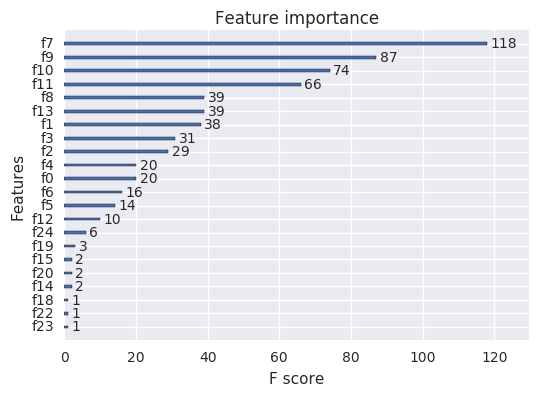

In [12]:
import matplotlib.pyplot as plt
import datetime as dt

clf = make_pipeline(StandardScaler(), XGBClassifier(nthread=-1))
start_time = dt.datetime.now()
scores = cross_val_score(clf, X.values, Y.values, cv = 10, scoring = 'accuracy', n_jobs = 1)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
print('Duración', dt.datetime.now()-start_time)

clf.fit(X.values, Y.values)
xgboost.plot_importance(clf.steps[1][1], ax=plt.gca())

### XGBOOST CON MATRIZ DE CONFUSIÓN

In [13]:
## Definimos vectores de entrenamiento y test
from sklearn.cross_validation import train_test_split 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=100)

In [14]:
print("Number of training records: " + str(X_train.size))
print("Number of testing records : " + str(X_test.size))

Number of training records: 194125
Number of testing records : 21575


In [15]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])
pipeline.fit(X_train.values, Y_train.values)
#xgboost.plot_importance(pipeline.steps[1][1])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

In [16]:
Y_pred = pipeline.predict(X_test.values)

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()

print('tn = ', tn, ', fp = ', fp, ', fn = ',fn, ', tp = ',tp)

tn =  313 , fp =  112 , fn =  102 , tp =  336


### XGBOOST CON OPTIMIZACIÓN DE AUC

In [17]:
import numpy as np 
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
from xgboost import plot_tree
import random
import time
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt

/gpfs/fs01/user/s57f-73edb3521eee1d-79e3f294add4/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [18]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [19]:
def get_importance(gbm, features):
    #create_feature_map(features)
    importance = gbm.get_fscore()
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

In [20]:
def get_features(train, test):
    trainval = list(train.columns.values)
    output = trainval
    return sorted(output)

In [21]:
def run_single(X_train, X_valid, y_train, y_valid, features, random_state=0):
    eta = 1.0
    max_depth= 6 
    subsample = 1
    colsample_bytree = 1
    min_chil_weight=1
    start_time = time.time()

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "min_chil_weight":min_chil_weight,
        "seed": random_state,
        #"num_class" : 22,
    }
    num_boost_round = 500
    early_stopping_rounds = 20
    test_size = 0.1

   
    
    #X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    print('Length train:', X_train.shape[0])
    print('Length valid:', X_valid.shape[0])
    #y_train = X_train[target]
    #y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train, missing=-99, feature_names=features)
    dvalid = xgb.DMatrix(X_valid[features], y_valid, missing =-99, feature_names=features)

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid[features]), ntree_limit=gbm.best_iteration+1)
    
    #area under the precision-recall curve
    score = average_precision_score(y_valid.values, check)
    print('area under the precision-recall curve: {:.6f}'.format(score))

    
    check2=check.round()
    score = precision_score(y_valid.values, check2)
    print('precision score: {:.6f}'.format(score))

    score = recall_score(y_valid.values, check2)
    print('recall score: {:.6f}'.format(score))
    
    imp = get_importance(gbm, features)
    xgboost.plot_importance(gbm)
    print('Importance array: ', imp)

    print("Predict test set... ")
    #fea = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14']
    test_prediction = gbm.predict(xgb.DMatrix(X_valid[features],missing = -99), ntree_limit=gbm.best_iteration+1)
    score = average_precision_score(y_valid.values, test_prediction)

    print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
    ############################################ ROC Curve
     
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_valid.values, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################
    
    # Plot tree
    plt.figure()
    plot = plot_tree(gbm, num_trees=2, rankdir='LR')
    fig = plot.get_figure()
    fig.savefig('xgboost_tree.eps', format='eps', dpi=2000)
    plt.show()

    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    return test_prediction, imp, gbm.best_iteration+1

Start time:  2017-12-15 05:48:33.967993
['std_pago_unired', 'max_pago_unired', 'avg_pago_unired', 'pago_unired_mensual', 'avg_dia_pago_unired', 'max_dia_pago_unired', 'min_dia_pago_unired', 'avg_pago_retail_mensual', 'max_pago_retail_mensual', 'std_pago_retail_mensual', 'SPEND_AMT', 'DISCOUNT_AMT', 'GENDER', 'EDAD', 'MOBILE_CONTACTABILITY', 'EMAIL_CONTACTABILITY', 'GSE_ABC1', 'GSE_C2', 'GSE_C3', 'GSE_D', 'GSE_E', 'CIVIL_STATUS_CASADO', 'CIVIL_STATUS_DIVORCIADO', 'CIVIL_STATUS_SOLTERO', 'CIVIL_STATUS_VIUDO']
Building model..  0:00:00.000647
XGBoost params. ETA: 1.0, MAX_DEPTH: 6, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Length train: 7765
Length valid: 863
[0]	train-auc:0.788675	eval-auc:0.748367
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 20 rounds.
[1]	train-auc:0.851052	eval-auc:0.79939
[2]	train-auc:0.892178	eval-auc:0.849906
[3]	train-auc:0.909357	eval-auc:0.864703
[4]	train-auc:0.928034	eval-auc:0.8814

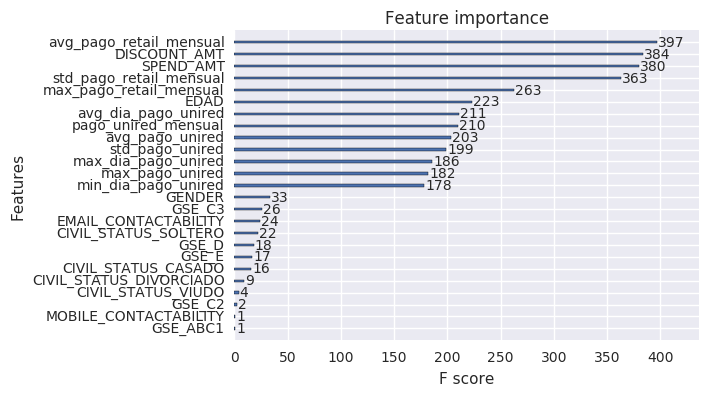

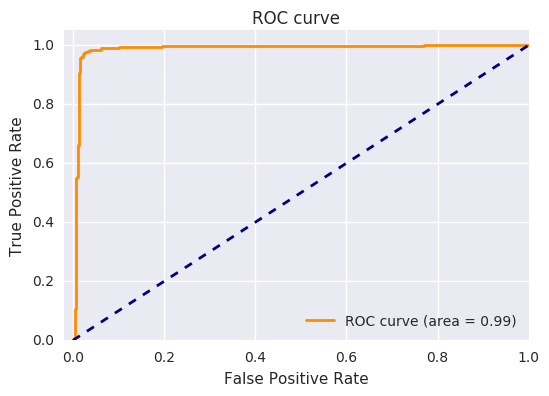

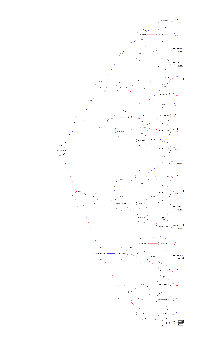

Training time: 4.13 minutes
0:04:07.672512


In [22]:
start_time = dt.datetime.now()
print("Start time: ",start_time)
features = X_train.columns.values.tolist()
print(features)

print("Building model.. ",dt.datetime.now()-start_time)
#X_train, X_valid, y_train, y_valid, features, random_state=0
preds, imp, num_boost_rounds = run_single(X_train, X_test, Y_train, Y_test, features, 100)

 
print(dt.datetime.now()-start_time)

# DETERMINACIÓN DE PAGO BLOQUEADOS

In [23]:
pd_boost = bloq2bal

In [24]:
pd_boost.head()

,CUSTOMER_ID,std_pago_unired,max_pago_unired,avg_pago_unired,pago_unired_mensual,avg_dia_pago_unired,max_dia_pago_unired,min_dia_pago_unired,avg_uso_tarjeta,PAYMENT_MEAN_ID,...,std_pago_retail_mensual,SPEND_AMT,DISCOUNT_AMT,GENDER,EDAD,MOBILE_CONTACTABILITY,EMAIL_CONTACTABILITY,GSE,CIVIL_STATUS,bloqueo
0,14295828,34786.587006,135466,54942.416667,659309,5.089003,10.153817,0.707107,0.250000,0,...,19159.363619,260589,23785,FEMENINO,60,1,1,C3,CASADO,0
1,30174068,22804.835996,97050,50127.857143,350895,5.595878,6.363961,4.949747,0.142857,0,...,5602.529458,29387,1633,FEMENINO,59,1,0,E,DIVORCIADO,1
2,54612656,4587.755442,43850,38700.000000,116100,2.819995,4.932883,0.707107,0.000000,0,...,23359.003782,218009,22955,FEMENINO,42,1,0,C3,DIVORCIADO,0
3,99841158,24316.463764,77890,39529.000000,395290,10.563605,10.563605,10.563605,0.005102,0,...,56429.884905,1037580,247719,FEMENINO,51,1,0,E,CASADO,0
4,70026320,28030.667045,104700,63497.000000,317485,9.364604,11.150486,7.778175,0.477157,1,...,38881.129212,1100191,128563,MASCULINO,48,1,0,C3,SOLTERO,0


In [25]:
## One Hot Encoder para GSE
pd_boost = pd.get_dummies(pd_boost, columns=["GSE"])

In [26]:
## One Hot Encoder para CIVIL_STATUS
pd_boost = pd.get_dummies(pd_boost, columns=["CIVIL_STATUS"])

In [27]:
## Reemplazamos por diccionario el Genero
dict_GEN = {"GENDER":{"FEMENINO":0, "MASCULINO":1}}
pd_boost.replace(dict_GEN, inplace=True)

In [28]:
## Reemplazamos todos los nan por ceros
name_col  = list(pd_boost)

for name in name_col:
    if name != 'CUSTOMER_ID':
        error = pd_boost[pd_boost[name].isnull() == True]
        if len(error) > 0:
            pd_boost[name].fillna(0, inplace=True)

## MODELO XGBOOST

## XGBOOST CON CROSSVALIDATION

In [29]:
## Definimos vectores X e Y 
Y = pd_boost['bloqueo'].map(lambda d: 1 if d == 1 else 0)
X = pd_boost.drop(['PAYMENT_MEAN_ID', 'CUSTOMER_ID', 'bloqueo'], axis=1)

In [30]:
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import plot_importance
from matplotlib import pyplot
import pprint

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

%matplotlib inline

Accuracy: 0.82 (+/- 0.02)
Duración 0:10:47.009878


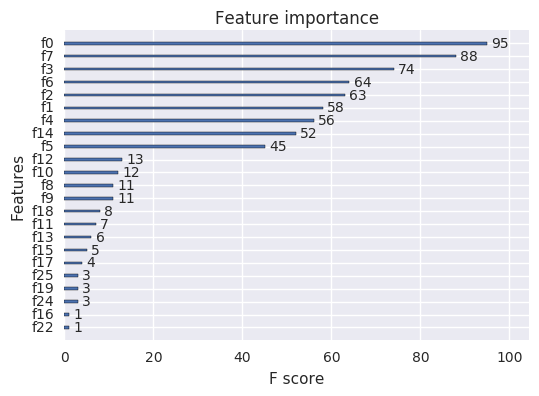

In [31]:
import matplotlib.pyplot as plt
import datetime as dt

clf = make_pipeline(StandardScaler(), XGBClassifier(nthread=-1))
start_time = dt.datetime.now()
scores = cross_val_score(clf, X.values, Y.values, cv = 10, scoring = 'accuracy', n_jobs = 1)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
print('Duración', dt.datetime.now()-start_time)

clf.fit(X.values, Y.values)
xgboost.plot_importance(clf.steps[1][1], ax=plt.gca())

### XGBOOST CON MATRIZ DE CONFUSIÓN

In [32]:
## Definimos vectores de entrenamiento y test
from sklearn.cross_validation import train_test_split 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [33]:
print("Number of training records: " + str(X_train.size))
print("Number of testing records : " + str(X_test.size))

Number of training records: 386230
Number of testing records : 165542


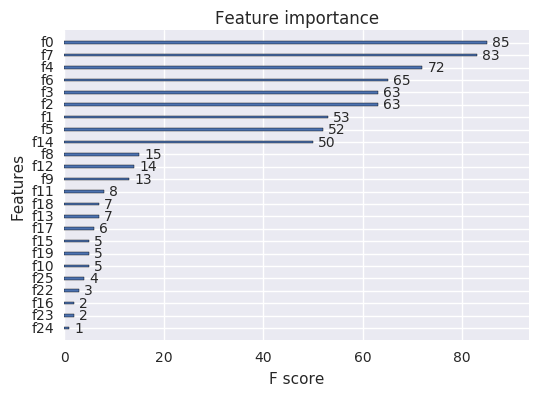

In [34]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])
pipeline.fit(X_train.values, Y_train.values)
xgboost.plot_importance(pipeline.steps[1][1])

In [35]:
Y_pred = pipeline.predict(X_test.values)

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()

print(tn, fp, fn, tp)

2503 674 444 2746


### XGBOOST CON OPTIMIZACIÓN DE AUC

In [36]:
import numpy as np 
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
from xgboost import plot_tree
import random
import time
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt

In [37]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [38]:
def get_importance(gbm, features):
    #create_feature_map(features)
    importance = gbm.get_fscore()
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

In [39]:
def get_features(train, test):
    trainval = list(train.columns.values)
    output = trainval
    return sorted(output)

In [40]:
def run_single(X_train, X_valid, y_train, y_valid, features, random_state=0):
    eta = 1.0
    max_depth= 6 
    subsample = 1
    colsample_bytree = 1
    min_chil_weight=1
    start_time = time.time()

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "min_chil_weight":min_chil_weight,
        "seed": random_state,
        #"num_class" : 22,
    }
    num_boost_round = 500
    early_stopping_rounds = 20
    test_size = 0.1

   
    
    #X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    print('Length train:', X_train.shape[0])
    print('Length valid:', X_valid.shape[0])
    #y_train = X_train[target]
    #y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train, missing=-99, feature_names=features)
    dvalid = xgb.DMatrix(X_valid[features], y_valid, missing =-99, feature_names=features)

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid[features]), ntree_limit=gbm.best_iteration+1)
    
    #area under the precision-recall curve
    score = average_precision_score(y_valid.values, check)
    print('area under the precision-recall curve: {:.6f}'.format(score))

    
    check2=check.round()
    score = precision_score(y_valid.values, check2)
    print('precision score: {:.6f}'.format(score))

    score = recall_score(y_valid.values, check2)
    print('recall score: {:.6f}'.format(score))
    
    imp = get_importance(gbm, features)
    xgboost.plot_importance(gbm)
    print('Importance array: ', imp)

    print("Predict test set... ")
    #fea = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14']
    test_prediction = gbm.predict(xgb.DMatrix(X_valid[features],missing = -99), ntree_limit=gbm.best_iteration+1)
    score = average_precision_score(y_valid.values, test_prediction)

    print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
    ############################################ ROC Curve
     
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_valid.values, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################
    
    # Plot tree
    plt.figure()
    plot = plot_tree(gbm, num_trees=2, rankdir='LR')
    fig = plot.get_figure()
    fig.savefig('xgboost_tree.eps', format='eps', dpi=2000)
    plt.show()

    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    return test_prediction, imp, gbm.best_iteration+1

In [41]:
# Any results you write to the current directory are saved as output.
start_time = dt.datetime.now()
print("Start time: ",start_time)

Start time:  2017-12-15 06:05:38.898566


['std_pago_unired', 'max_pago_unired', 'avg_pago_unired', 'pago_unired_mensual', 'avg_dia_pago_unired', 'max_dia_pago_unired', 'min_dia_pago_unired', 'avg_uso_tarjeta', 'avg_pago_retail_mensual', 'max_pago_retail_mensual', 'std_pago_retail_mensual', 'SPEND_AMT', 'DISCOUNT_AMT', 'GENDER', 'EDAD', 'MOBILE_CONTACTABILITY', 'EMAIL_CONTACTABILITY', 'GSE_ABC1', 'GSE_C2', 'GSE_C3', 'GSE_D', 'GSE_E', 'CIVIL_STATUS_CASADO', 'CIVIL_STATUS_DIVORCIADO', 'CIVIL_STATUS_SOLTERO', 'CIVIL_STATUS_VIUDO']
Building model..  0:00:00.010207
XGBoost params. ETA: 1.0, MAX_DEPTH: 6, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Length train: 14855
Length valid: 6367
[0]	train-auc:0.79743	eval-auc:0.80109
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 20 rounds.
[1]	train-auc:0.868817	eval-auc:0.861897
[2]	train-auc:0.911658	eval-auc:0.903615
[3]	train-auc:0.947301	eval-auc:0.935234
[4]	train-auc:0.964128	eval-auc:0.95583
[5]	train-auc:0.97

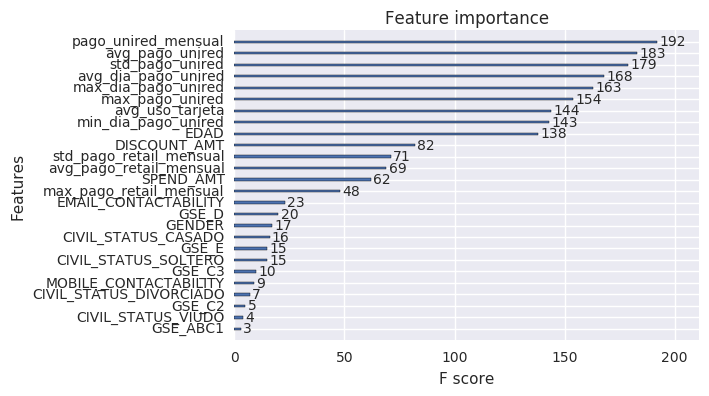

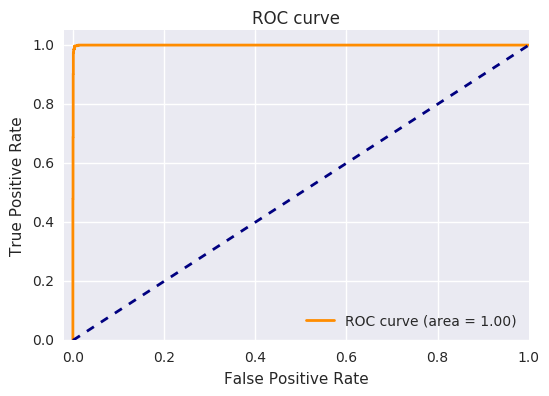

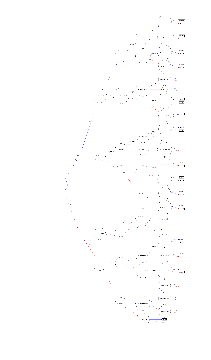

Training time: 1.9 minutes
0:01:54.030968


In [42]:
features = X_train.columns.values.tolist()
print(features)

print("Building model.. ",dt.datetime.now()-start_time)
#X_train, X_valid, y_train, y_valid, features, random_state=0
preds, imp, num_boost_rounds = run_single(X_train, X_test, Y_train, Y_test, features, 100)

 
print(dt.datetime.now()-start_time)